In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.integrate import trapezoid, solve_ivp

<center><img src="https://raw.githubusercontent.com/marcus-valmeida/Projeto-conversao/vn/circuito_exercicio3.png" alt="Circuito Exercício 3" width="500"></center>


In [114]:
B = np.array([0, 0.2, 0.6,  0.7,  0.75, 0.8,  0.85, 0.96, 1.02, 1.05, 1.08, 1.11, 1.13, 1.15, 1.18, 1.2 ])
H = np.array([-50200, -49500, -48000, -47000, -46000, -45000, -44000, -40000, -35000,-30000, -25000, -20000, -15000, -10000, -5000, 0])

# Dados "lineares" 
B_linear = np.array([0.0, 1.2])
H_linear = np.array([-50200, 0.0])

g0 = 1*1e-3
W = 4*1e-2
D = 3.5*1e-2
d = 8*1e-3
N1 = 1000
U0 = 4*np.pi*1e-7

Area = W*D # Area do imã = Area do entreferro(x) = Area do entreferro(g0)

num_pontos = 200

#para o caso linear
Ur_linear = (B_linear[0]- B_linear[1])/(H_linear[0]-H_linear[1])

#para o caso real



#### Considere inicialmente que não há corrente na bobina. Apresente um gráfico para a força magnética que surge no elemento móvel nas condições a seguir:   
- Considerando uma aproximação linear da forma:  
$$
B_{\mathrm{m}} = \mu_{\mathrm{R}} (H_{\mathrm{m}} - H_{\mathrm{c}}^{\prime})
$$
- Considerando a curva BxH fornecida para o imã.


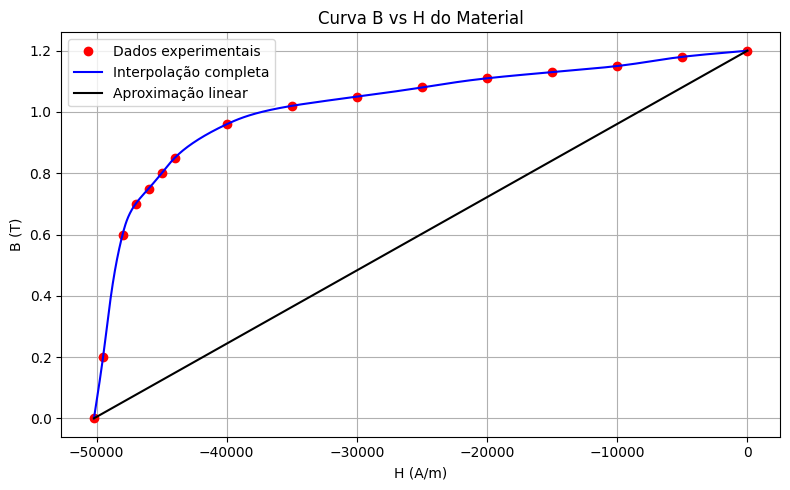

In [115]:
# Interpolação cúbica (ordem crescente de B)
f_real = CubicSpline(B, H, bc_type='natural')
f_linear = CubicSpline(B_linear, H_linear, bc_type='natural')

# Geração de pontos para interpolação
B_a = np.linspace(min(B), max(B), num_pontos)
H_a = f_real(B_a)
H_linear_a = f_linear(B_a)

# Plotagem
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(H, B, 'ro', label='Dados experimentais')
ax.plot(H_a, B_a, 'b-', label='Interpolação completa')
ax.plot(H_linear_a, B_a, 'k-', label='Aproximação linear')

ax.set_title('Curva B vs H do Material')
ax.set_xlabel('H (A/m)')
ax.set_ylabel('B (T)')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


### Gráfico para a força magnética

In [116]:
def Coenergia_forca(Interpolacao_H_B, Nf):
    # variação de x
    x = np.linspace(0, 0.02, num_pontos)# 20 mm em metros

    # variação de Bm
    Bm = np.linspace(0, 1.2, num_pontos)
    # Corrente ficticia -> Inicia um vetor com todos os valores nulos
    If = np.zeros(num_pontos)
    # Fluxo concatenado
    fluxo_concatenado = np.zeros(num_pontos)
    Coenergia = np.zeros(num_pontos)

    #caso onde não calculamos por bobina ficticia
    CoenergiaN1000 = np.zeros(num_pontos)

    for j in range(len(x)):
      for b in range(len(Bm)):

        # If = (Hi*d + Bm*[x + g0]/U0) /Nf
        If[b] = ((Interpolacao_H_B(Bm[b])*d) + ((Bm[b]*(x[j]+g0)/U0)))/Nf

        # λ =  Nf * Bm * Area_do_imã
        fluxo_concatenado[b] =  Nf*Bm[b]*Area

        if (f"{x[j]:.4f}" == "0.0005"):  # Posição do elemento móvel
            # Encontrando os valores da densidade de fluxo B para a corrente If
            Bm_x = np.copy(Bm)
            If_x = np.copy(If)

      # Interpolação de λ , Bm, If
      interpolacao_fluxo_concatenado_If = CubicSpline(If,fluxo_concatenado)
      interpolacao_If_Bm = CubicSpline(Bm,If)

      #parte inferior da integral, ponto onde B = 0
      If_0 = interpolacao_If_Bm(0)
      #limite de integração do λ
      lim_int_fluxo_concatenado = np.linspace(If_0, 0, num_pontos)
      #valores para coenergia
      interpol_fluxo_concatenado = interpolacao_fluxo_concatenado_If(lim_int_fluxo_concatenado)
      #valores para coenergia
      Coenergia[j] = trapezoid(interpol_fluxo_concatenado,lim_int_fluxo_concatenado) 
      
      Bop_normal = 1.08
      Hop_normal = -31.14*1e+3
      xop_normal = 0.5*1e-3
      #valor da corrente quando está em operação normal
      Iop_normal =   ((-Hop_normal*d) + Bop_normal*((xop_normal + g0)/U0))/Nf
      
      Iint_Nf_1000 = np.linspace(If_0,Iop_normal,num_pontos)
      Fluxo_concat_Interpolado_Nf_1000 = interpolacao_fluxo_concatenado_If(Iint_Nf_1000)
      CoenergiaN1000[j] = trapezoid(Fluxo_concat_Interpolado_Nf_1000,Iint_Nf_1000)

    #caso de operação normal  
    if(Nf == 1000):
      Forca = np.gradient(CoenergiaN1000[:len(x)-1], x[:len(x)-1])
      return Forca, CoenergiaN1000[:len(CoenergiaN1000)-1],(x[:len(x)-1]), Bm_x, If_x, Iop_normal 

    #caso da bobina ficticia
    else:
      Forca = np.gradient(Coenergia[:len(x)-1], x[:len(x)-1])
      return Forca, Coenergia[:len(Coenergia)-1],(x[:len(x)-1])

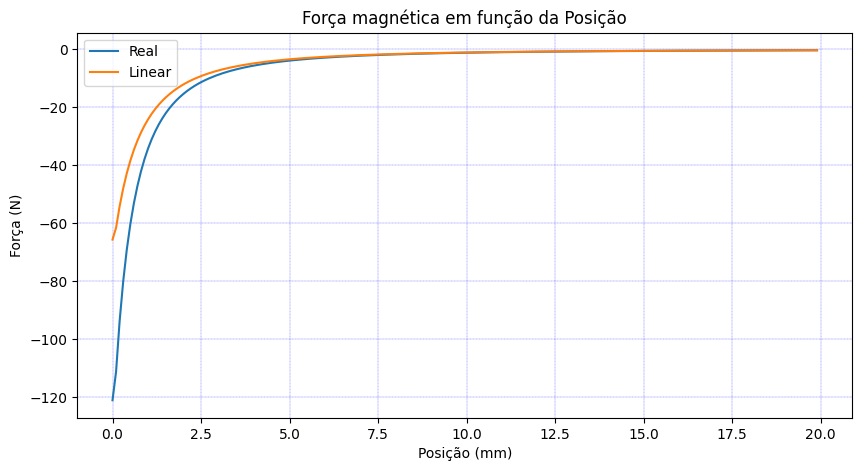

In [117]:
# ----- Cálculo -----
Forca_real, Co_energia_real, posicao  = Coenergia_forca(f_real, 1)
Forca_linear, Co_energia_linear, posicao = Coenergia_forca(f_linear, 1)

# ----- Plot -----
plt.figure(figsize=[10,5])
plt.plot(posicao*1000, Forca_real, label="Real")    # x em mm
plt.plot(posicao*1000, Forca_linear, label="Linear")
plt.xlabel("Posição (mm)")
plt.ylabel("Força (N)")
plt.title("Força magnética em função da Posição")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.2, color='blue')
plt.show()



### Considere agora a existência de corrente na bobina

- Para um elemento móvel na posição $x = 0,5 mm$, apresente um gráfico da densidade de fluxo ($B$) no entreferro em função da corrente  
  aplicada na bobina;

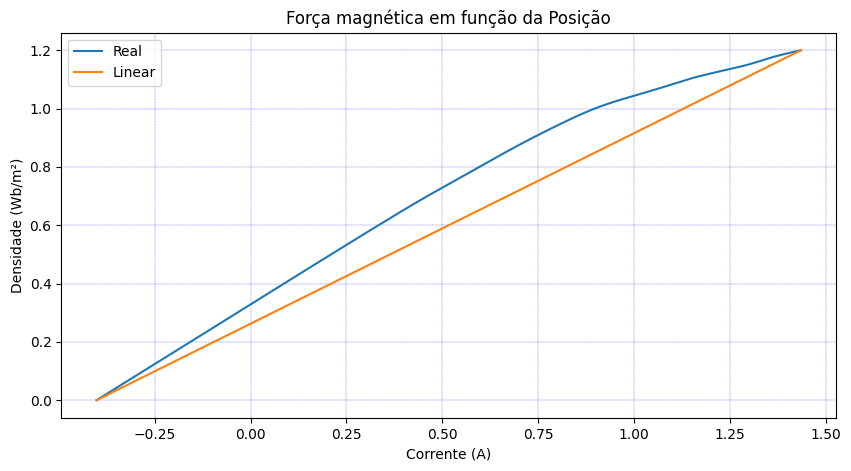

In [118]:
# ----- Cálculo -----
Forca_real, Co_energia_real, posicao, Bm_real, If_real, If_normal = Coenergia_forca(f_real, 1000)
Forca_linear, Co_energia_linear, posicao, Bm_linear, If_linear,_ = Coenergia_forca(f_linear, 1000)

# ----- Plot -----
plt.figure(figsize=[10,5])
plt.plot(If_real, Bm_real, label="Real")
plt.plot(If_linear, Bm_linear, label="Linear")
plt.xlabel("Corrente (A)")
plt.ylabel("Densidade (Wb/m²)")
plt.title("Força magnética em função da Posição")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.2, color='blue')
plt.show()

- Considere que é aplicada na bobina uma corrente constante tal que, para o corpo na posição x= 0,5mm, o sistema esteja no ponto de
operação normal indicado pelo fabricante do imã. Nessas condições, apresente um gráfico para a força magnética em função da posição $x$

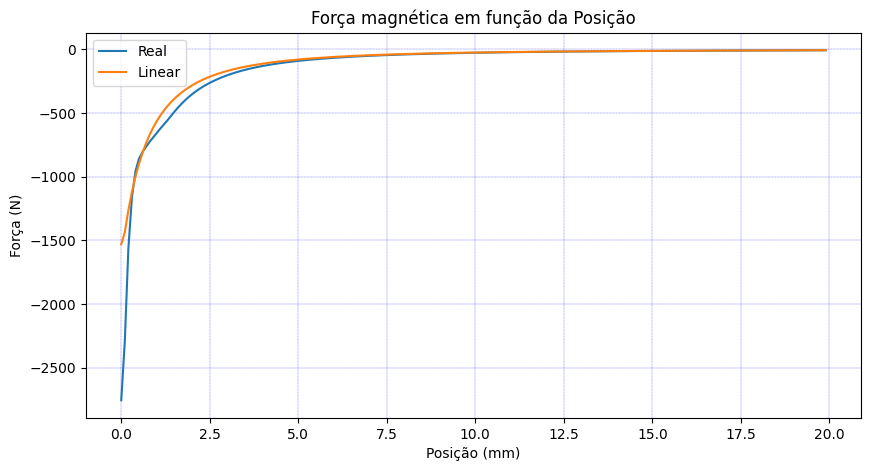

In [119]:
# ----- Cálculo -----
Forca_real, Co_energia_real, posicao,*_ = Coenergia_forca(f_real, 1000)
Forca_linear, Co_energia_linear, posicao,*_ = Coenergia_forca(f_linear, 1000)

# ----- Plot -----
plt.figure(figsize=[10,5])
plt.plot(posicao*1000, Forca_real, label="Real")    # x em mm
plt.plot(posicao*1000, Forca_linear, label="Linear")
plt.xlabel("Posição (mm)")
plt.ylabel("Força (N)")
plt.title("Força magnética em função da Posição")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.2, color='blue')
plt.show()


- Considerando a corrente calculada no item anterior e que no instante inicial o corpo esteja na posição x= 0,4mm. Considere ainda que  a massa do corpo seja 10% maior que o necessário para que ele caia sobe a ação da gravidade, apresente um gráfico da posição do corpo em função do tempo até ele deixar o entreferro.

In [120]:
# --- CONDIÇÕES INICIAIS ---
x_inicial = 0.0004                                              # 0.4 mm
v_inicial = 0.0
y0 = [x_inicial, v_inicial]

# --- PARÂMETROS DA SIMULAÇÃO ---
t_inicial = 0
t_final_estimado = 0.1
t_span = [t_inicial, t_final_estimado]

# Considerações iniciais:
# A questão pede para considerar a corrente constante calculada na operação normal (Iop_normal) para o cálculo da força.
If = If_normal

# Precisamos da Força magnética para qualquer posição x do elemento móvel e determinar a força inicial na posição x = 0.4 mm.
forca_magnetica = CubicSpline(posicao, Forca_real)

# Determinando a massa do elemento móvel real e em equlibrio com a gravidade.
forca_inicial = forca_magnetica(0.0004)
massa_equilibrio = np.abs(forca_inicial)/ 9.81              # m = forca / g
massa_real = 1.10 * massa_equilibrio                        # 10% a mais que o equilíbrio

print(f"Força inicial na posição x = 0.4 mm: {forca_inicial:.4f} N")
print(f"Massa do elemento móvel em equilíbrio: {massa_equilibrio:.4f} kg")
print(f"Massa do elemento móvel real: {massa_real:.4f} kg")

Força inicial na posição x = 0.4 mm: -959.9375 N
Massa do elemento móvel em equilíbrio: 97.8530 kg
Massa do elemento móvel real: 107.6383 kg


In [121]:
def equacao_movimento(t, y, massa, funcao_forca):
    
    posicao, velocidade = y
    
    # Força magnética (atrativa, para "cima", positiva)
    forca_magnetica_atual = np.abs(funcao_forca(posicao))
    
    # Força resultante é a força magnética menos a força peso
    forca_resultante = forca_magnetica_atual - (massa * 9.81)
    
    # Aceleração resultante
    aceleracao = forca_resultante / massa

    
    return [-velocidade, aceleracao]

In [122]:
def evento_parada(t, y, massa, funcao_forca):
    """
    Evento para parar a simulação quando a posição atinge o mínimo.
    """
    # y[0] é a posição. O evento ocorre quando esta função retorna 0.
    return y[0] - 0.02

evento_parada.terminal = True  # Define que a simulação DEVE parar no evento.
evento_parada.direction = 1   # O evento só é válido quando a função está diminuindo (posição caindo para g_min).

Simulação concluída com sucesso. O corpo deixou o entreferro em 0.0929 segundos.


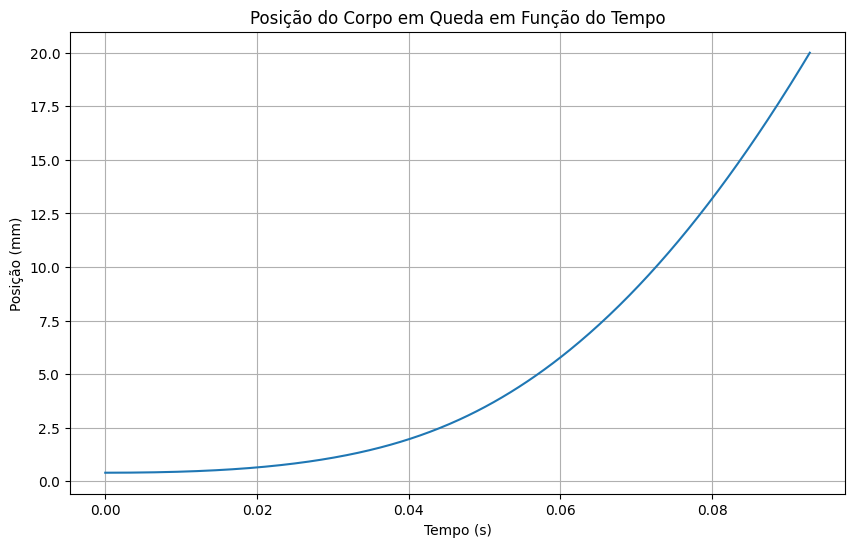

In [123]:
# --- RESOLVENDO A EDO COM A FUNÇÃO CORRIGIDA ---
solucao = solve_ivp(
    fun = equacao_movimento, 
    t_span = t_span,
    y0 = y0,
    method = "RK45", 
    dense_output = True,
    events = evento_parada,
    args = (massa_real, forca_magnetica)
)

# --- EXTRAINDO E PLOTANDO OS RESULTADOS ---
if solucao.status == 1:
    print(f"Simulação concluída com sucesso. O corpo deixou o entreferro em {solucao.t_events[0][0]:.4f} segundos.")
    
    t_plot = np.linspace(solucao.t[0], solucao.t[-1], 500)
    posicao_plot = solucao.sol(t_plot)[0]
    
    plt.figure(figsize=(10, 6))
    plt.plot(t_plot, posicao_plot * 1000) # Convertendo para mm
    plt.title("Posição do Corpo em Queda em Função do Tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Posição (mm)")
    plt.grid(True)
    plt.show()

elif solucao.status == 0:
    print("Simulação concluída porque o tempo final foi atingido, mas o evento de parada não ocorreu.")
else:
    print(f"A solução falhou com o status: {solucao.status}")